In [1]:
%%capture capt
!pip install matplotlib torchsummary scikit-learn pandas
!pip install -U imbalanced-learn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from torchsummary import summary

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneGroupOut

In [2]:
from gilbert2d import gilbert2d

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model running on {device}.")

Model running on cuda.


## Data Loading

In [4]:
CLASSES = ["asymetric", "banded", "locked", "butterfly", "no_pattern"]

In [5]:
# Mapping int to categories
int_to_cat = {
    0: "asymetric",
    1: "banded",
    2: "locked",
    3: "butterfly",
    4: "no_pattern",
}

In [6]:
X_train = np.load("./data/X_train.npy")
y_train_df = pd.read_csv("./data/y_train.csv")

In [7]:
X_test = np.load("./data/X_test.npy")
y_test_df = pd.read_csv("./data/y_test.csv")

## SMOTE

In [8]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE

In [9]:
sm = SMOTE(k_neighbors=10)
#sm = KMeansSMOTE(k_neighbors=5)

In [11]:
X_train = X_train.reshape(len(X_train), -1)
X_train, y_train = sm.fit_resample(X_train, y_train_df.cat_num.values)
X_train = X_train.reshape(-1, 90, 180)

## Flatten with Peano curve

In [13]:
def flatten_peano(X):
    peano_indices = np.array(list(gilbert2d(X[0].shape[0], X[0].shape[1])))
    flat_indices = X[0].shape[1] * peano_indices[:, 0] + peano_indices[:, 1]
    return X.reshape(-1, X[0].shape[0]*X[0].shape[1])[:, flat_indices]

In [14]:
def max_pool(img, factor=3):
    """ Perform max pooling with a (factor x factor) kernel"""
    ds_img = np.full((img.shape[0] // factor, img.shape[1] // factor), -float('inf'), dtype=img.dtype)
    np.maximum.at(ds_img, (np.arange(img.shape[0])[:, None] // factor, np.arange(img.shape[1]) // factor), img)
    return ds_img

vectorized_max_pool = np.vectorize(max_pool, signature='(m,n)->(k,l)')

In [16]:
def black_and_white(X):
    return np.where(X > 0.5, 1, 0)

In [17]:
flattened_img_train = flatten_peano(vectorized_max_pool(black_and_white(X_train)))
flattened_img_test = flatten_peano(vectorized_max_pool(black_and_white(X_test)))

/opt/mamba/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [21]:
# Convert to PyTorch tensors
X_train = torch.tensor(np.array(flattened_img_train), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(np.array(flattened_img_test), dtype=torch.float32)
y_test = torch.tensor(y_test_df['cat_num'].values, dtype=torch.long)

In [22]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [23]:
print(f"X_train shape -> {X_train.shape}, y_train shape -> {y_train.shape}")
print(f"X_test shape -> {X_test.shape}, y_test shape -> {y_test.shape}")

X_train shape -> torch.Size([1660, 1800]), y_train shape -> torch.Size([1660])
X_test shape -> torch.Size([68, 1800]), y_test shape -> torch.Size([68])


## Display

In [24]:
def plot(x, title, ax):
    shape0 = int(np.sqrt(len(x)/2))
    ax.imshow(x.reshape(shape0, 2*shape0), cmap='gray')
    ax.set_title(title)

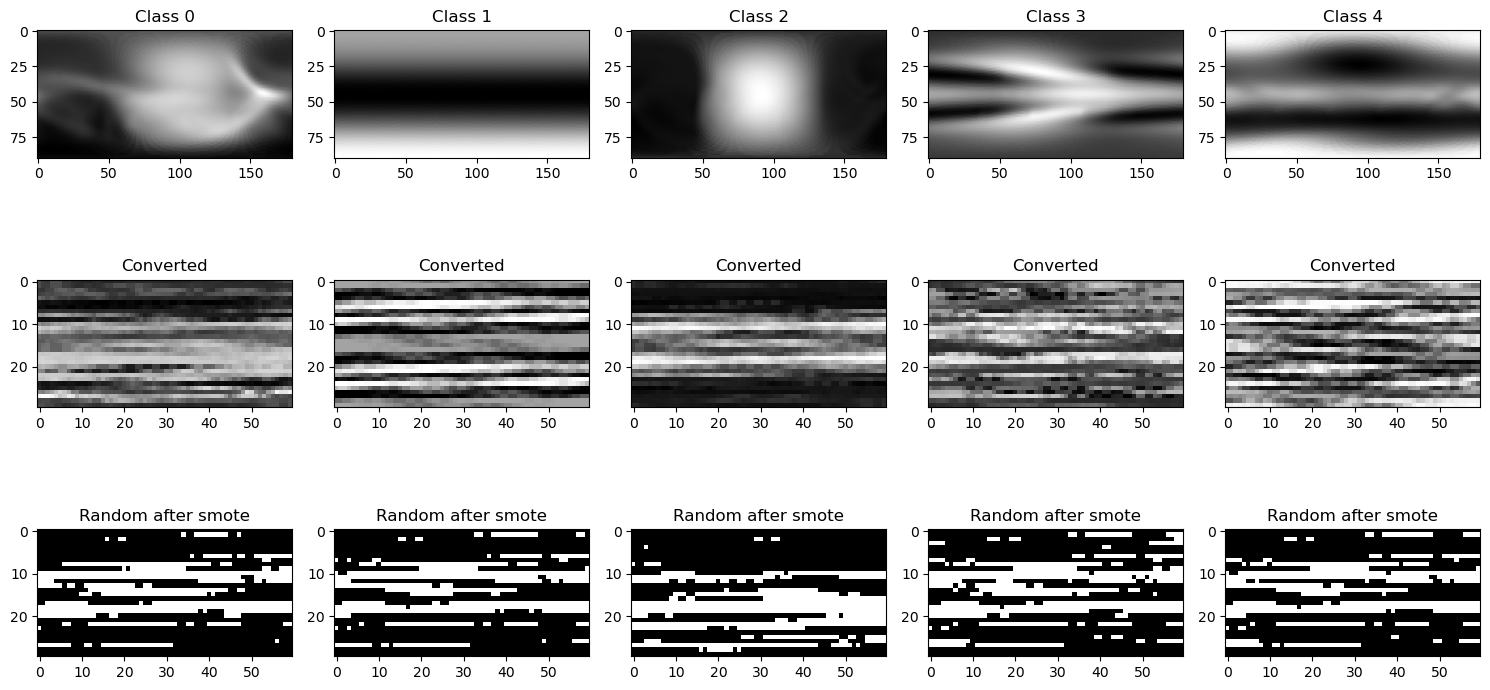

In [25]:
fig, axs = plt.subplots(3, 5, figsize=(15, 8))

for class_ in range(5):
    X_class_ = np.load("./data/X_train.npy")[pd.read_csv("./data/y_train.csv").cat_num.values == class_]
    x = X_class_[np.random.choice(range(len(X_class_)))].flatten()
    ax = axs[0][class_]
    plot(x, f'Class {class_}', ax)

    plot(flatten_peano(np.array([max_pool(x.reshape(90, 180))]))[0], 'Converted', axs[1][class_])

    plot_x_class = X_train.cpu().numpy()[np.random.choice(range(len(X_train)), size=1)]
    plot(plot_x_class[0], 'Random after smote', axs[2][class_])
plt.tight_layout()

# Train model

## Train functions

In [26]:
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [27]:
import torch.nn.functional as F

class ImageLSTM(nn.Module):
    def __init__(self, input_size, lstm_outsize, num_layers, hidden_n, num_classes, bidirectional=True):
        super(ImageLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, lstm_outsize, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc1 = nn.Linear(lstm_outsize * num_layers, hidden_n)
        self.fc_out = nn.Linear(hidden_n, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = F.relu(self.fc1(lstm_out))
        out = self.fc_out(x)
        return x

In [28]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)

    def forward(self, x):
        cur_batch_size = x.shape[0]
        x = x.view(-1, cur_batch_size, self.hidden_size)

        # Apply self-attention
        attn_output, _ = self.attention(x, x, x)

        # Reshape back to (sequence_length * batch_size * hidden_size)
        attn_output = attn_output.view(-1, self.hidden_size)
        return attn_output

class ImageLSTMWithAttention(nn.Module):
    def __init__(self, input_size, lstm1, lstm2, num_layers, hidden_n, num_classes, num_attention_heads,
                 bidirectional=True, dropout_rate=0.5, add_attention=True):
        super(ImageLSTMWithAttention, self).__init__()
        self.add_attention = add_attention

        n_lstm = 2 if bidirectional else 1

        self.lstm1 = nn.LSTM(input_size, lstm1, num_layers, batch_first=True, bidirectional=bidirectional, dropout=0.3)
        self.lstm2 = nn.LSTM(n_lstm * lstm1, lstm2, num_layers, batch_first=True, bidirectional=bidirectional, dropout=0.3)
        self.self_attention = SelfAttention(lstm2 * n_lstm, num_attention_heads)
        self.dropout_lstm = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(lstm2 * n_lstm * (2 if self.add_attention else 1), hidden_n)
        self.dropout_fc = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_n, hidden_n // 2)
        self.fc_out = nn.Linear(hidden_n // 2, num_classes)
        self.lstm1_layerNorm = nn.LayerNorm(n_lstm * lstm1)
        self.lstm2_layerNorm = nn.LayerNorm(lstm2 * n_lstm * (2 if self.add_attention else 1))

    def forward(self, x):
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.lstm1_layerNorm(lstm_out1)
        lstm_out1 = self.dropout_lstm(lstm_out1)
        #lstm_out2, _ = self.lstm2(lstm_out1)

        if self.add_attention:
            attention_output = self.self_attention(lstm_out2)
            lstm_out2 = torch.cat([lstm_out2, attention_output], dim=-1)
            
        #lstm_out2 = self.dropout_lstm(lstm_out2)
        #lstm_out2 = self.lstm2_layerNorm(lstm_out2)

        lstm_out2 = lstm_out1
        
        fc1_out = F.relu(self.fc1(lstm_out2))
        fc1_out = self.dropout_fc(fc1_out)
        fc2_out = F.relu(self.fc2(fc1_out))
        fc2_out = self.dropout_fc(fc2_out)
        
        out = self.fc_out(fc2_out)
        return out

In [29]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    epoch_train_loss = 0.0
    all_predictions = []
    all_labels = []

    for images, labels in train_loader:
        #images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        # Collect predictions and labels for balanced accuracy calculation
        _, predictions = torch.max(outputs.data, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_train_loss /= len(train_loader)

    # Calculate balanced accuracy on the training set
    train_balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
    train_acc = accuracy_score(all_labels, all_predictions)

    return epoch_train_loss, train_acc, train_balanced_acc

In [30]:
def validate(model, val_loader, criterion, criterion__test=None):
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_loss__test = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            if criterion__test is not None:
                loss__test = criterion__test(outputs, labels)
                epoch_val_loss__test += loss__test.item()
            epoch_val_loss += loss.item()

            _, predictions = torch.max(outputs.data, 1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss /= len(val_loader)
    epoch_val_loss__test /= len(val_loader)
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
    acc = accuracy_score(all_labels, all_predictions)

    if criterion__test is not None:
        return epoch_val_loss, epoch_val_loss__test, acc, balanced_acc
    return epoch_val_loss, acc, balanced_acc

In [31]:
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, num_epochs, criterion__test=None, plot_every=None, patience=np.inf):
    best_val_loss = float('inf')
    best_val_balanced = 0
    counter = 0

    epoch_val_loss, epoch_val_loss__test = 0., 0.
    def print_metrics(epoch, epoch_val_loss=epoch_val_loss):
      print(f"Epoch [{epoch+1}/{num_epochs}] - "
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Validation Loss: {epoch_val_loss:.4f}, "
            f"Train Accuracy: {train_accuracy:.4f}, "
            f"Valid Accuracy: {val_accuracy:.4f}, "
            f"Train B. Accuracy: {train_balanced_acc:.4f}, "
            f"Validation B. Accuracy: {val_balanced_acc:.4f}, "
            f"Time / epoch: {round(stop-start, 2)}s")

    if plot_every is None:
      plot_every = int(num_epochs/10)

    for epoch in range(num_epochs):
        # Training
        start = time.time()
        epoch_train_loss, train_accuracy, train_balanced_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(train_accuracy)
        train_balanced_accuracies.append(train_balanced_acc)

        # Validation
        if criterion__test is not None:
            epoch_val_loss, epoch_val_loss__test, val_accuracy, val_balanced_acc = validate(model, val_loader, criterion, criterion__test=criterion__test)
        else:
            epoch_val_loss, val_accuracy, val_balanced_acc = validate(model, val_loader, criterion, criterion__test=criterion__test)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)
        val_balanced_accuracies.append(val_balanced_acc)
        stop = time.time()

        if val_balanced_acc >= best_val_balanced:
            torch.save(model.state_dict(), "./model_dict.pt")
            torch.save(model, "./model.pt")
            best_val_balanced = val_balanced_acc

        if epoch % plot_every == 0 or epoch == num_epochs-1:
          print_metrics(epoch, epoch_val_loss__test if criterion__test is not None else epoch_val_loss)

        # Patience mechanism
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print_metrics(epoch)
                break

    return train_losses, val_losses, train_accuracies, val_accuracies, train_balanced_accuracies, val_balanced_accuracies

## Training

In [32]:
from sklearn.utils.class_weight import compute_class_weight

class_weights__train = compute_class_weight('balanced', classes=np.unique(y_train.cpu()), y=y_train.cpu().numpy())
class_weights__train = torch.tensor(class_weights__train, dtype=torch.float32).to(device)

class_weights__test = compute_class_weight('balanced', classes=np.unique(y_test.cpu()), y=y_test.cpu().numpy())
class_weights__test = torch.tensor(class_weights__test, dtype=torch.float32).to(device)

print(class_weights__train, class_weights__test)

tensor([1., 1., 1., 1., 1.], device='cuda:0') tensor([1.3600, 2.2667, 3.4000, 2.2667, 0.3238], device='cuda:0')


In [33]:
input_size = X_train.shape[1]
lstm1 = 256
lstm2 = 256
num_layers = 2
hidden_n = 64
bidirectional = True
num_classes = 5
num_attention_heads = 8
num_epochs = 2000
learning_rate = 1e-6
patience = int(num_epochs/10)+np.inf

add_attention = False

#model = ImageLSTM(input_size, lstm1, num_layers, hidden_n, num_classes, bidirectional=bidirectional)
model = ImageLSTMWithAttention(input_size, lstm1, lstm2, num_layers, hidden_n, num_classes, num_attention_heads, bidirectional=True, dropout_rate=0.5, add_attention=add_attention)
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1, 1, 1, 1.2], dtype=torch.float32).to(device))
#criterion = nn.CrossEntropyLoss(weight=class_weights__train)
criterion__test = nn.CrossEntropyLoss(weight=class_weights__test)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

In [34]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_balanced_accuracies = []
val_balanced_accuracies = []

train_losses, val_losses, train_accuracies, val_accuracies, train_balanced_accuracies, val_balanced_accuracies = train_with_early_stopping(
    model, train_loader, test_loader, nn.CrossEntropyLoss(weight=torch.tensor([1, 1, 1, 1, 1.4], dtype=torch.float32).to(device)), 
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0), 5*num_epochs, plot_every=50, patience=patience, criterion__test=None
)

Epoch [1/10000] - Train Loss: 1.6212, Validation Loss: 1.5743, Train Accuracy: 0.2090, Valid Accuracy: 0.5735, Train B. Accuracy: 0.2090, Validation B. Accuracy: 0.2429, Time / epoch: 0.63s
Epoch [51/10000] - Train Loss: 1.5689, Validation Loss: 1.5180, Train Accuracy: 0.2651, Valid Accuracy: 0.6176, Train B. Accuracy: 0.2651, Validation B. Accuracy: 0.4000, Time / epoch: 0.36s
Epoch [101/10000] - Train Loss: 1.4998, Validation Loss: 1.3766, Train Accuracy: 0.3211, Valid Accuracy: 0.6324, Train B. Accuracy: 0.3211, Validation B. Accuracy: 0.3071, Time / epoch: 0.31s
Epoch [151/10000] - Train Loss: 1.4245, Validation Loss: 1.2642, Train Accuracy: 0.3898, Valid Accuracy: 0.5441, Train B. Accuracy: 0.3898, Validation B. Accuracy: 0.2619, Time / epoch: 0.37s
Epoch [201/10000] - Train Loss: 1.3470, Validation Loss: 1.3093, Train Accuracy: 0.4373, Valid Accuracy: 0.4412, Train B. Accuracy: 0.4373, Validation B. Accuracy: 0.3629, Time / epoch: 0.38s
Epoch [251/10000] - Train Loss: 1.3019, Val

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(train_losses, label='Train loss')
axs[0].plot(val_losses, label='Test loss')

axs[1].plot(train_balanced_accuracies, label='Train Balanced Acc')
axs[1].plot(val_balanced_accuracies, label='Test Balanced Acc')

axs[2].plot(train_accuracies, label='Train Accuracy')
axs[2].plot(val_accuracies, label='Test Accuracy')

for ax in axs:
    ax.legend()
    ax.grid('on')

plt.tight_layout()
plt.show()

In [ ]:
# Model in evaluation mode
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    _, y_pred = torch.max(outputs, 1)

    outputs_train = model(X_train)
    _, y_train_pred = torch.max(outputs_train, 1)

y_pred = y_pred.cpu().numpy()
y_train_pred = y_train_pred.cpu().numpy()

In [ ]:
print(accuracy_score(y_test.cpu(), y_pred), balanced_accuracy_score(y_test.cpu(), y_pred))
accuracy_score(y_train.cpu(), y_train_pred), balanced_accuracy_score(y_train.cpu(), y_train_pred)

In [ ]:
print(classification_report(y_test.cpu(), y_pred))

In [ ]:
print(classification_report(y_train.cpu(), y_train_pred))

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test.cpu(), y_pred)
fig = disp.figure_
fig.set_figwidth(7)
fig.set_figheight(7)  
plt.title("Confusion Matrix - test set");

In [ ]:
for i in range(len(y_pred)):
    if y_pred[i] == 0:
        print(f'True {y_test.cpu()[i]}')
        print(outputs[i].cpu())
        print(nn.Softmax(1)(outputs)[i].cpu())
        print()

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_train.cpu(), y_train_pred)
fig = disp.figure_
fig.set_figwidth(7)
fig.set_figheight(7)  
plt.title("Confusion Matrix - train set");

## Ramp

In [77]:
class Classifier():
    def __init__(self):
        self.model = model

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y

    def predict(self, X):
        return

    def predict_proba(self, X):
        # Create an array of zeros
        y_pred = np.zeros((X.shape[0], 5), dtype=int)
        # Set one random index per row to 1
        for i in range(X.shape[0]):
            random_index = random.randint(0, 4)
            y_pred[i, random_index] = 1
        return np.array(y_pred)

In [78]:
!ramp-test --submission starting_kit

Testing Hot Jupiter atmospheric pattern classification
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train      0.2  0.535  0.009778
	valid      0.2  0.537  0.000182
	test       0.2  0.618  0.000020
CV fold 1
	score  bal_acc    acc      time
	train      0.2  0.598  0.009918
	valid      0.2  0.390  0.000166
	test       0.2  0.618  0.000019
CV fold 2
	score  bal_acc    acc      time
	train      0.2  0.467  0.008288
	valid      0.2  0.652  0.000162
	test       0.2  0.618  0.000019
----------------------------
Mean CV scores
----------------------------
	score    bal_acc             acc       time
	train  0.2 ± 0.0  0.533 ± 0.0537  0.0 ± 0.0
	valid  0.2 ± 0.0  0.526 ± 0.1071  0.0 ± 0.0
	test   0.2 ± 0.0     0.618 ± 0.0  0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid      0.2  0.535
	test       0.2  0.618
